In [14]:
import time
import os
import glob
import csv
import numpy as np
import pandas as pd
from scipy import stats
import openai
import matplotlib.pyplot as plt
import seaborn as sns

# File locations
dir = '/Users/Federica_1/Documents/GitHub/endoQAeval'
data_dir = os.path.join(dir, 'data')
out_dir = os.path.join(dir, 'output')
fig_dir = os.path.join(dir, 'figures')

In [15]:
endoq = pd.read_csv(os.path.join(data_dir, 'questions_evaluation - Endo questions.csv'), usecols=range(0,6)).iloc[0:301]
endoq.dropna(subset=['question_id'], inplace=True)
endoq[:1]

,question_id,question,type1,type2,type 3,side effects
0,Endo_d8bcw7_post,I had a lap on 5/10/19 and my gyno said my bla...,manifestation,NaN,NaN,False


In [16]:
genq = pd.read_csv(os.path.join(data_dir, 'questions_evaluation - General questions.csv'), usecols=range(0,7)).iloc[0:101]
genq.dropna(subset=['question_id'], inplace=True)
genq.drop(columns=['reddit_id'], inplace=True)
genq[:1]

,question_id,question,type1,type2,type 3,side effects
0,N2,"28F, ex smoker, no drinking, 5'3"", 200lbs. Its...",manifestation,NaN,NaN,False


In [17]:
all_q = pd.concat([endoq,genq])
all_q

,question_id,question,type1,type2,type 3,side effects
0,Endo_d8bcw7_post,I had a lap on 5/10/19 and my gyno said my bla...,manifestation,NaN,NaN,False
3,endometriosis_dn70ay_post,Hello. Where do I start? I had bad cramping ...,manifestation,diagnosis,NaN,False
6,Endo_bdo5m3_post,Hi everyone! I'm new to this. I have my first ...,diagnosis,management,NaN,False
9,endometriosis_op3b4i_post,"so, I got up, started walking, and immediately...",manifestation,diagnosis,NaN,False
12,endometriosis_elx4k2_post,"I’m 15, and I got my first period in may. Wasn...",manifestation,diagnosis,NaN,False
...,...,...,...,...,...,...
95,N136,"16M, 166cm, 49kg, I do not smoke, drink or do ...",manifestation,diagnosis,NaN,False
96,N137,20M 150lb 5'8\n\nSlightly above and left of my...,manifestation,diagnosis,NaN,False
97,N141,"29M 5'8"" 165lbs. Don't smoke, drink or do drug...",management,NaN,NaN,False
98,N143,"20f and i‰Ûªve had a bad cold recently, many c...",manifestation,diagnosis,NaN,False


In [18]:
questions_pivot = []

for index, row in all_q.iterrows():
    for col in ['type1', 'type2', 'type 3']:
        if not pd.isna(row[col]):
            d = {'question_id': row['question_id'],
                 'question': row['question'],
                 'qtype': row[col]
                 }
            questions_pivot.append(d)

qtypes = pd.DataFrame.from_dict(questions_pivot)
qtypes[:5]

,question_id,question,qtype
0,Endo_d8bcw7_post,I had a lap on 5/10/19 and my gyno said my bla...,manifestation
1,endometriosis_dn70ay_post,Hello. Where do I start? I had bad cramping ...,manifestation
2,endometriosis_dn70ay_post,Hello. Where do I start? I had bad cramping ...,diagnosis
3,Endo_bdo5m3_post,Hi everyone! I'm new to this. I have my first ...,diagnosis
4,Endo_bdo5m3_post,Hi everyone! I'm new to this. I have my first ...,management


In [19]:
qtypes['qtype'].value_counts()/qtypes['qtype'].count()*100

management        34.767025
manifestation     31.182796
diagnosis         26.523297
cause              2.867384
information        1.792115
susceptibility     1.433692
anatomy            0.716846
complication       0.358423
prognosis          0.358423
Name: qtype, dtype: float64

In [20]:
annotations = pd.read_csv(os.path.join(out_dir, 'all_annotations.csv'), index_col=0)
grouped = annotations.groupby(['question_id', 'question', 'response', 'response_id',
       'Prompt', 'Medical Concern', 'Annotator Type', 'Metric'], as_index=False).mean()
grouped[:1]

,question_id,question,response,response_id,Prompt,Medical Concern,Annotator Type,Metric,Annotator,Score
0,Endo_2xjk3k_post,I'm in the UK if that makes a difference! Basi...,weight management in patients with pcos (polyc...,endoR142,doc_prompt,Endometriosis,Patient,Actionability,2.5,2.0


In [21]:
merged = pd.merge(left=qtypes, left_on=['question_id', 'question'], right=grouped, right_on=['question_id', 'question'])
merged[:1]

,question_id,question,qtype,response,response_id,Prompt,Medical Concern,Annotator Type,Metric,Annotator,Score
0,Endo_d8bcw7_post,I had a lap on 5/10/19 and my gyno said my bla...,manifestation,"as an ai, i don't have the ability to diagnose...",endoR0,no_prompt,Endometriosis,Patient,Actionability,2.5,2.0


In [22]:
merged3 = merged[(merged['qtype'] == 'management')
                              | (merged['qtype'] == 'manifestation')
                              | (merged['qtype'] == 'diagnosis')]

In [23]:
merged3[:1]

,question_id,question,qtype,response,response_id,Prompt,Medical Concern,Annotator Type,Metric,Annotator,Score
0,Endo_d8bcw7_post,I had a lap on 5/10/19 and my gyno said my bla...,manifestation,"as an ai, i don't have the ability to diagnose...",endoR0,no_prompt,Endometriosis,Patient,Actionability,2.5,2.0


In [24]:
def make_boxplots(df, _fig_dir):
    
    _figure = plt.figure(figsize = (3.3*3,5), tight_layout=0.5)
    plt.suptitle(f'Performance for Endomentriosis Responses Across Prompting Strategies')
    pos = 1

    metrics = ["Information Quality","Empathy","Actionability"]

    for metric in metrics:

        _figure.add_subplot(1,3,pos)
        data = df[(df['Medical Concern'] == 'Endometriosis') & (df['Metric'] == metric)]

        ax = sns.boxplot(data=data, x='qtype', y='Score',
                         order=['management', 'manifestation', 'diagnosis'])
        ax.set_xticklabels(['Management', 'Manifestation', 'Diagnosis'])
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=30)
        ax.set_ylim(0,5.5)

        if pos == 2:
            ax.set_ylabel('')
            ax.yaxis.set_tick_params(color='white')
            ax.set_yticklabels([])

        else:
            ax.set_ylabel(f'Score')

        if pos == 3:
            ax.set_ylim(0,3.5)
            ax.set_yticks([0,1,2,3])
        
        ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
        plt.title(f'{metric}')
        pos += 1

        _figure.savefig(os.path.join(_fig_dir, f'question_types.png'), dpi = 300, bbox_inches = "tight")

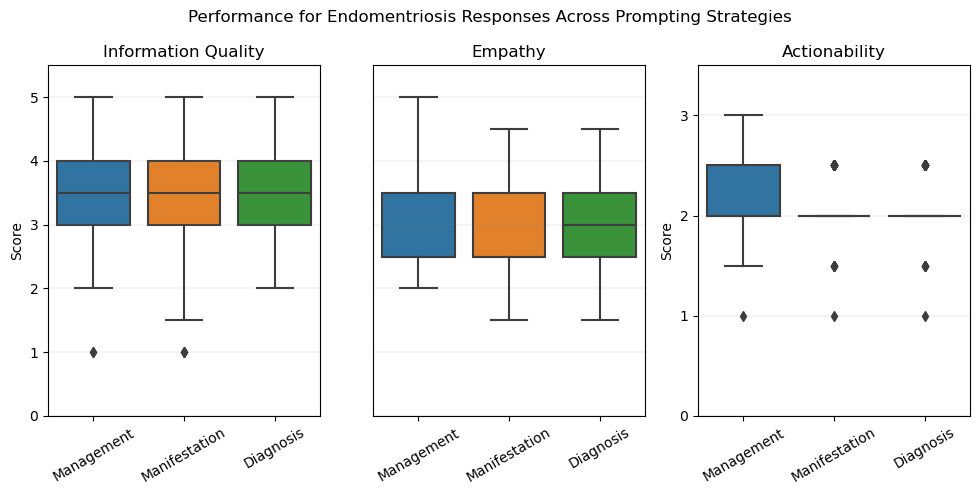

In [25]:
make_boxplots(merged3, fig_dir)

In [28]:
for metric in ["Information Quality","Empathy","Actionability"]:
   print(metric)
   for prompt_pair in [('doc_prompt', 'no_prompt'), ('doc_prompt', 'pat_prompt'), ('pat_prompt', 'no_prompt')]:

      x = merged3[(merged3['Medical Concern'] == 'Endometriosis')
         & (merged3['Prompt'] == prompt_pair[0])
         & (merged3['Metric'] == metric)]['Score'].values
      
      y = merged3[(merged3['Medical Concern'] == 'Endometriosis')
         & (merged3['Prompt'] == prompt_pair[1])
         & (merged3['Metric'] == merged3)]['Score'].values
   
      print(f'{prompt_pair[0]} and {prompt_pair[1]}')

      if stats.mannwhitneyu(x, y, alternative='two-sided')[1] < 0.05 and stats.wilcoxon(x, y, alternative='two-sided')[1] < 0.05:

         print(stats.mannwhitneyu(x, y, alternative='two-sided'))
         print(stats.wilcoxon(x, y, alternative='two-sided'),'\n')
      else:
         print('Not statistically significant\n')
   print('_______________')

Information Quality


/var/folders/6r/l85qcy_s4pb2p4w5r1tfc0t00000gn/T/ipykernel_13736/2075466320.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  & (merged3['Metric'] == merged3)]['Score'].values


doc_prompt and no_prompt
Not statistically significant

doc_prompt and pat_prompt
Not statistically significant

pat_prompt and no_prompt
Not statistically significant

_______________
Empathy
doc_prompt and no_prompt
Not statistically significant

doc_prompt and pat_prompt
Not statistically significant

pat_prompt and no_prompt
Not statistically significant

_______________
Actionability
doc_prompt and no_prompt
Not statistically significant

doc_prompt and pat_prompt
Not statistically significant

pat_prompt and no_prompt
Not statistically significant

_______________
